## import necessary libraries

In [1]:
import numpy  as np
import matplotlib.pyplot as plt
import gym
from collections import defaultdict

## set environment

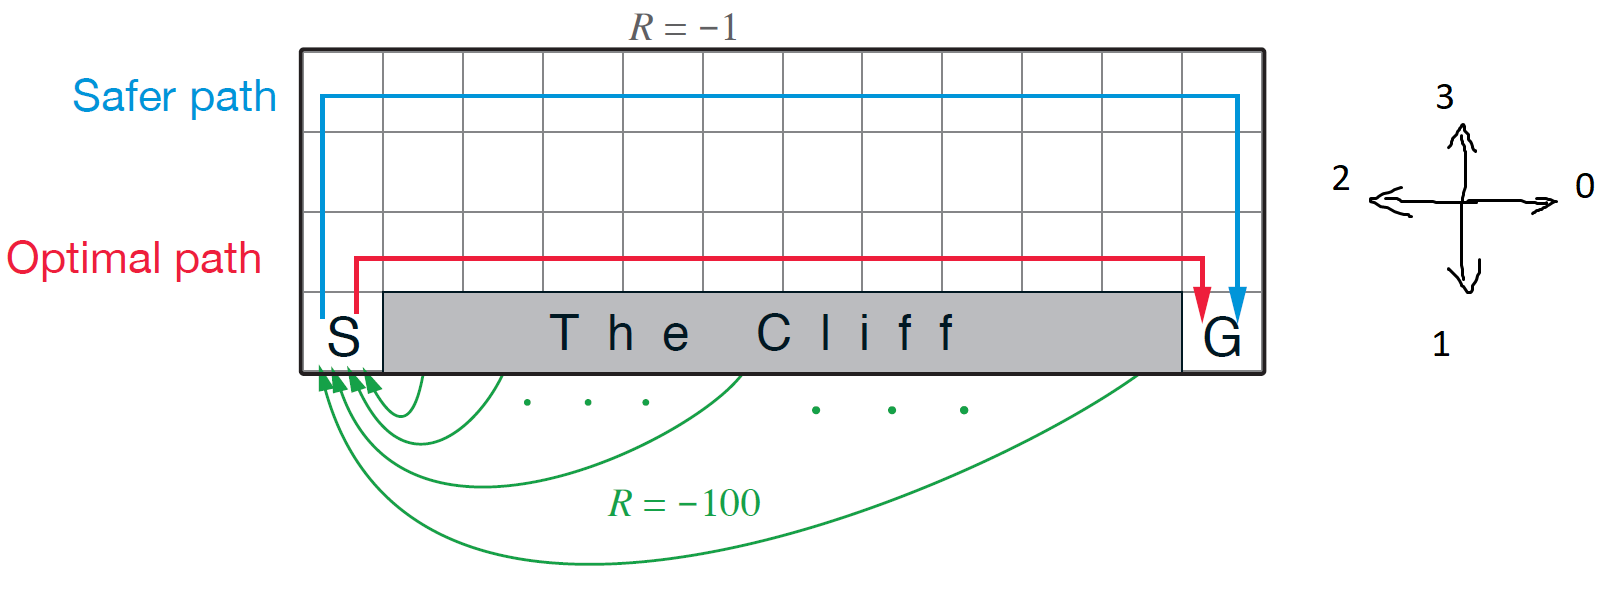

In [56]:
class cliff_env():
    def __init__(self):
        '''
        our environment is a grid world with 4 rows and 12 columns
        location of the agent in this world specified with (row number , column number) tuple'''
        self.fall_zone=[]
        for col in range(1,11):
            self.fall_zone.append((0,col))
    def reset(self):
        # returns initial state , reward , done, info
        return (0,0),0,False,'start state in left below corner'
        
    def step(self,current_state,action):
        '''takes current state and action, returns next state , reward , done'''
        if action ==0: # right
            if current_state[1]+1>11:
                next_state=(current_state[0],current_state[1])
            else:
                next_state=(current_state[0],current_state[1]+1)
                
        if action ==1: # down
            if current_state[0]-1<0:
                next_state=(current_state[0],current_state[1])
            else:
                next_state=(current_state[0]-1,current_state[1])
        if action ==2: # left
            if current_state[1]-1<0:
                next_state=(current_state[0],current_state[1])
            else :
                next_state=(current_state[0]-1,current_state[1])

        if action ==3: # up
            if current_state[0]+1 >3:
                next_state=(current_state[0],current_state[1])
            else:
                next_state=(current_state[0]+1,current_state[1])
        
        # return to start state after falling
        if next_state in self.fall_zone:

            reward=-100
            next_state=(0,0)
            done=False
        elif next_state==(0,11):
            reward=-1
            done=True
        else:
            reward=-1
            done=False
        return next_state,reward,done
env=cliff_env()

In [58]:
# test environment
# expected output : ((0, 11), -1, True)
env.step((1,11),1)

((0, 11), -1, True)

## sarsa implementation 

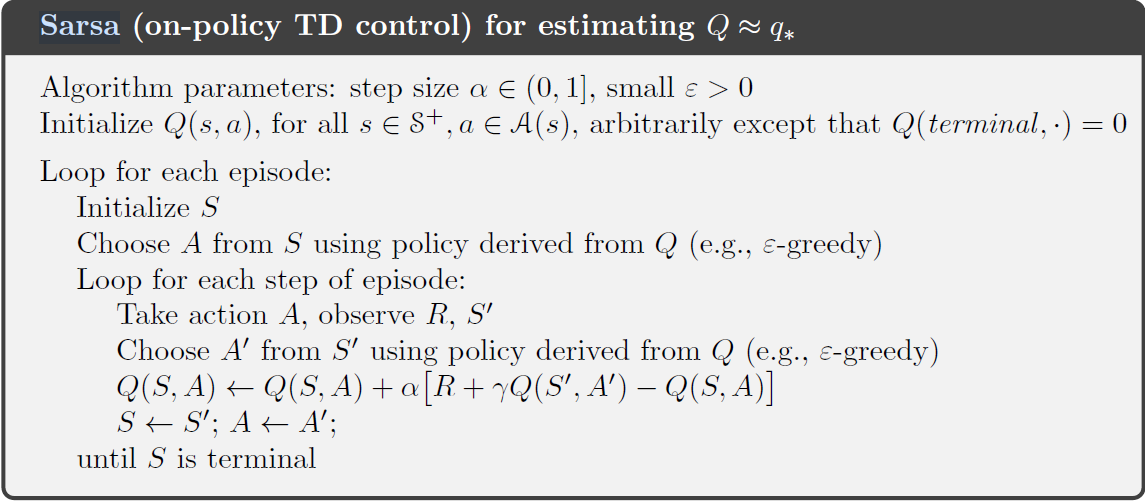

In [146]:
class SARSA():
    def __init__(self,env_,step_size,epsilon,apply_step_size):
        self.step_size=step_size
        self.apply_step_size=apply_step_size
        self.epsilon=epsilon
        self.N_s_a=defaultdict(int)
        self.Q_value=defaultdict(float)
        # set value of the terminla stete to zero
        '''terminal_state=12
        for action in range(0,4):  
            self.Q_value[(terminal_state,action)]=0'''
        self.cliff_env=env_
    
    def e_greedy_policy(self,state):
        if self.epsilon>=np.random.rand(1)[0]:
            action=np.random.choice(range(0,4))
        else :
            q_values=[]
            for action in range(0,4):
                q_values.append(self.Q_value[(state,action)])
            action=np.argmax(q_values)
        return action 
            
    def sarsa(self,num_episodes):
        sum_of_rewards=[]
        for episode in range(num_episodes):
            state,_,_,_=self.cliff_env.reset()
            action=self.e_greedy_policy(state)
            episode_reward=0
            done=False
            while done==False:
                # step method of environment returns {next state,reward , done ,{}}
                # take step and recieve observations
                next_state,reward,done=self.cliff_env.step(state,action)
                # choose next action from next state 
                next_action=self.e_greedy_policy(next_state)
                '''print('state----->',state)
                print('action----->',action)
                print('reward----->',reward)
                print('next state----->',next_state)
                print('done------->',done)'''
                
                # update Q-value function
                self.N_s_a[(state,action)]+=1
                if self.apply_step_size:
                    self.Q_value[(state,action)]=self.Q_value[(state,action)]+\
                    self.step_size*(reward+0.9*self.Q_value[(next_state,next_action)]-self.Q_value[(state,action)])
                else:
                    self.Q_value[(state,action)]=self.Q_value[(state,action)]+\
                    (1/self.N_s_a[(state,action)])*(reward+self.Q_value[(next_state,next_action)]-self.Q_value[(state,action)])
                state=next_state
                action=next_action
                episode_reward+=reward
                
            sum_of_rewards.append(episode_reward)
#         print(self.Q_value)
        return  sum_of_rewards,self.Q_value
            
        

In [251]:
sarsa_alrorithm=SARSA(env,0.3,0.1,True)
sum_of_rewards_sarsa,q_value_sarsa=sarsa_alrorithm.sarsa(500)


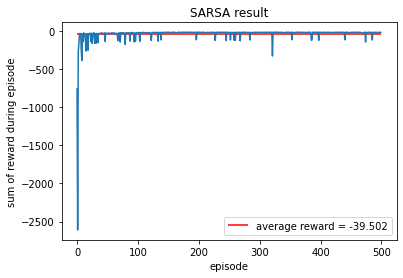

In [270]:
plt.title('SARSA result')
plt.xlabel('episode')
plt.ylabel('sum of reward during episode')
plt.hlines(xmax=500,xmin=0,y=np.average(sum_of_rewards_sarsa),
           color='r',label=f'average reward = {np.average(sum_of_rewards_sarsa)}')
plt.legend()

plt.plot(sum_of_rewards_sarsa)
plt.savefig('SARSA result')

## plot taken path with SARSA

In [241]:
def path(q_value,env):
    initial_state,_,_,_=env.reset()
    walked_path=[]
    initial_path=np.zeros((4,12))
    initial_path[0,0]+=1
    done=False
    walked_path.append(initial_state)
    while done==False:
        q_list=[]
        for action in range(0,4):
            q_list.append(q_value[(initial_state,action)])

        selected_action=int(np.argmax(q_list))

        if selected_action==0:
            initial_path[initial_state[0],initial_state[1]+1]+=1
            next_state,_,done=env.step(initial_state,selected_action)

        elif selected_action==1:
            initial_path[initial_state[0]-1,initial_state[1]]+=1
            next_state,_,done=env.step(initial_state,selected_action)

        elif selected_action==2:
            initial_path[initial_state[0],initial_state[1]-1]+=1
            next_state,_,done=env.step(initial_state,selected_action)

        elif selected_action==3:
            initial_path[initial_state[0]+1,initial_state[1]]+=1
            next_state,_,done=env.step(initial_state,selected_action)
        walked_path.append(next_state)
        initial_state=next_state
    return walked_path
        

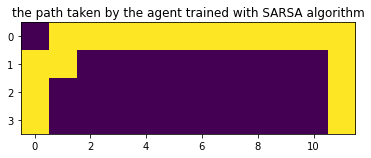

In [255]:
path_sarsa=path(q_value_sarsa,env)
path__sarsa=np.zeros((4,12))
for p in path_:
    path__sarsa[p[0],p[1]]+=1
plt.title('the path taken by the agent trained with SARSA algorithm')
plt.imshow(np.flip(path__sarsa,axis=0))
plt.savefig('SARSA path ')
plt.show()

## Q-learning implementation 

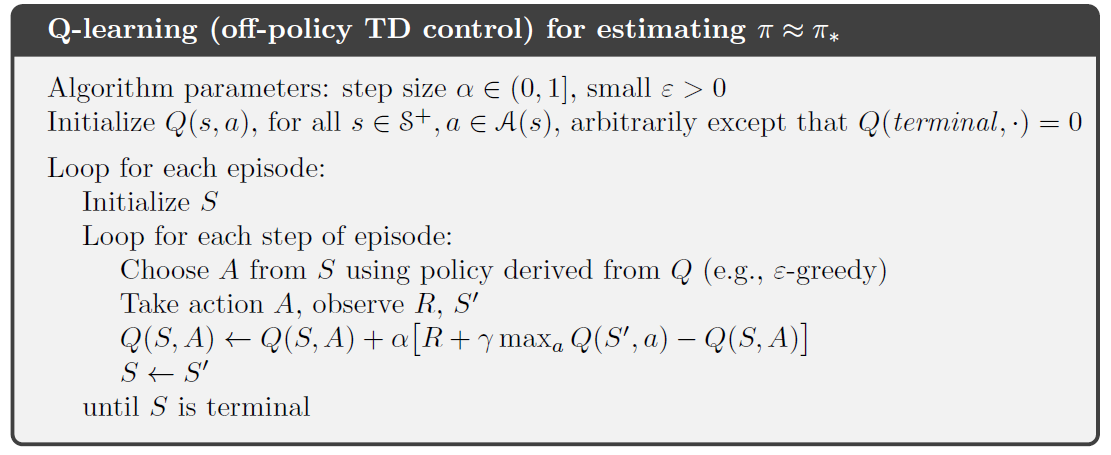

In [244]:
class Q_learning():
    def __init__(self,env_,step_size,epsilon,apply_step_size):
        self.step_size=step_size
        self.apply_step_size=apply_step_size
        self.epsilon=epsilon
        self.N_s_a=defaultdict(int)
        self.Q_value=defaultdict(float)
        # set value of the terminla stete to zero
        '''terminal_state=12
        for action in range(0,4):  
            self.Q_value[(terminal_state,action)]=0'''
        self.cliff_env=env_
    
    def e_greedy_policy(self,state):
        if self.epsilon>=np.random.rand(1)[0]:
            action=np.random.choice(range(0,4))
        else :
            q_values=[]
            for action in range(0,4):
                q_values.append(self.Q_value[(state,action)])
            action=np.argmax(q_values)
        return action 
    def max_next_stete(self,next_state):
        q_values=[]
        for action in range(0,4):
            q_values.append(self.Q_value[(next_state,action)])
        return max(q_values)
        print(max(q_values))
            
    def q_learner(self,num_episodes):
        sum_of_rewards=[]
        for episode in range(num_episodes):
            state,_,_,_=self.cliff_env.reset()
            
            episode_reward=0
            done=False
            while done==False:
                # step method of environment returns {next state,reward , done ,{}}
                # take step and recieve observations
                action=self.e_greedy_policy(state)
                next_state,reward,done=self.cliff_env.step(state,action)
                # choose next action from next state 
                '''print('state----->',state)
                print('action----->',action)
                print('reward----->',reward)
                print('next state----->',next_state)
                print('done------->',done)'''
                
                # update Q-value function
                self.N_s_a[(state,action)]+=1
                if self.apply_step_size:
                    self.Q_value[(state,action)]=self.Q_value[(state,action)]+\
                    self.step_size*(reward+0.9*self.max_next_stete(next_state)-self.Q_value[(state,action)])
                else:
                    self.Q_value[(state,action)]=self.Q_value[(state,action)]+\
                    (1/self.N_s_a[(state,action)])*(reward+0.9*self.max_next_stete(next_state)-self.Q_value[(state,action)])
                state=next_state
                episode_reward+=reward
                
            sum_of_rewards.append(episode_reward)
#         print(self.Q_value)
        return  sum_of_rewards,self.Q_value
            
        
    
    

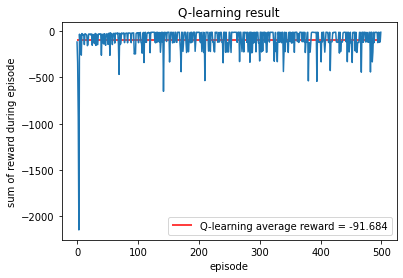

In [259]:
Q_learning_algorithm=Q_learning(env,0.3,0.1,True)
sum_of_rewards_Qlearning,q_value_Qlearning=Q_learning_algorithm.q_learner(500)
plt.title('Q-learning result')
plt.xlabel('episode')
plt.ylabel('sum of reward during episode')
plt.hlines(xmax=500,xmin=0,y=np.average(sum_of_rewards),color='r',label=f'Q-learning average reward = {np.average(sum_of_rewards)}')
plt.legend()
plt.plot(sum_of_rewards)
plt.savefig('Q-learning results')
plt.show()

## plot taken path with Q-learning

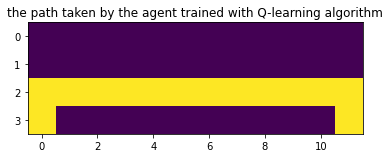

In [260]:
path_q_learning=path(q_value_Qlearning,env)
path__q=np.zeros((4,12))
for p in path_q_learning:
    path__q[p[0],p[1]]+=1
plt.title('the path taken by the agent trained with Q-learning algorithm')
plt.imshow(np.flip(path__q,axis=0))
plt.savefig('Q-learning path')
plt.show()

## comparing results

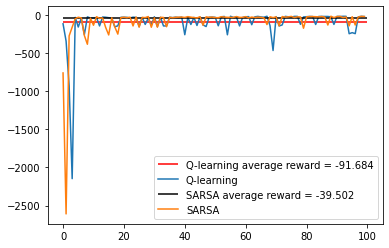

In [269]:
plt.hlines(xmax=100,xmin=0,y=np.average(sum_of_rewards),color='r',
           label=f'Q-learning average reward = {np.average(sum_of_rewards)}')
plt.plot(sum_of_rewards_Qlearning[:100],label='Q-learning')
plt.hlines(xmax=100,xmin=0,y=np.average(sum_of_rewards_sarsa),
           color='black',label=f'SARSA average reward = {np.average(sum_of_rewards_sarsa)}')
plt.plot(sum_of_rewards_sarsa[:100],label='SARSA')

plt.legend()
plt.savefig('compare two results')
